In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os

from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/MyDrive/first_try_of_fastai')

print("------------------------------------------------------------------")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
------------------------------------------------------------------


In [3]:
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

Overwriting setup.sh


In [4]:
!sh setup.sh

fatal: destination path 'apex' already exists and is not an empty directory.
/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-eomsyy99
Created temporary directory: /tmp/pip-req-tracker-immetkr4
Created requirements tracker '/tmp/pip-req-tracker-immetkr4'
Created temporary directory: /tmp/pip-install-336feza6
Processing ./apex
  Created temporary directory: /tmp/pip-req-build-fbtmi4mu
  Added file:///content/gdrive/My%20Drive/first_try_of_fastai/apex to build tracker '/tmp/pip-req-tracker-immetkr4'
    Running setup.py (path:/tmp/pip-req-build-fbtmi4mu/setup.py) egg_info for package from file:///content/gdrive/My%20Drive/first_try_of_fastai/apex
    Running command python setup.py egg_info


    torch.__version__  = 1.8.1+cu101


    running 

In [5]:
!git clone https://github.com/NVIDIA/apex
%cd apex
!pip install -v --no-cache-dir ./

fatal: destination path 'apex' already exists and is not an empty directory.
/content/gdrive/My Drive/first_try_of_fastai/apex
Created temporary directory: /tmp/pip-ephem-wheel-cache-cmuvjcf9
Created temporary directory: /tmp/pip-req-tracker-att0hnkk
Created requirements tracker '/tmp/pip-req-tracker-att0hnkk'
Created temporary directory: /tmp/pip-install-s9qbcr0w
Processing /content/gdrive/My Drive/first_try_of_fastai/apex
  Created temporary directory: /tmp/pip-req-build-3z7uxh0s
  Added file:///content/gdrive/My%20Drive/first_try_of_fastai/apex to build tracker '/tmp/pip-req-tracker-att0hnkk'
    Running setup.py (path:/tmp/pip-req-build-3z7uxh0s/setup.py) egg_info for package from file:///content/gdrive/My%20Drive/first_try_of_fastai/apex
    Running command python setup.py egg_info


    torch.__version__  = 1.8.1+cu101


    running egg_info
    creating /tmp/pip-req-build-3z7uxh0s/pip-egg-info/apex.egg-info
    writing /tmp/pip-req-build-3z7uxh0s/pip-egg-info/apex.egg-info/PKG-I

In [6]:
#export
import os
os.chdir('/content/gdrive/MyDrive/first_try_of_fastai/exp')
from nb_10c import *
os.chdir('/content/gdrive/MyDrive/first_try_of_fastai')

In [7]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [10]:
class CategoryProcessor(Processor):
    def __init__(self): self.vocab=None

    def __call__(self, items):
        #The vocab is defined on the first use.
        if self.vocab is None:
            self.vocab = uniqueify(items)
            self.otoi  = {v:k for k,v in enumerate(self.vocab)}
        return [self.proc1(o) for o in items]
    def proc1(self, item):  return self.otoi[item]

    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deproc1(idx) for idx in idxs]
    def deproc1(self, idx): return self.vocab[idx]


In [11]:
size = 128
tfms = [make_rgb, RandomResizedCrop(128, scale=(0.35,1)), np_to_float, PilRandomFlip()]

bs = 32

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name = 'val'))
ll = label_by_func(sd, parent_labeler, proc_y = CategoryProcessor())

ll.valid.x.tfms = [make_rgb, CenterCrop(size), np_to_float]

data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**XResNet**

In [29]:
#export
def noop(x): return x

class Flatten(nn.Module):
  def forward(self, x): return x.view(x.size(0), -1)

def conv(ni, nf, ks=3, stride=1, bias = False):
  return nn.Conv2d(ni, nf, kernel_size = ks, stride=stride, padding=ks//2, bias =bias)

In [30]:
#export
act_fn = nn.ReLU(inplace=True)

def init_cnn(m):
  if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
  if isinstance(m, (nn.Conv2d, nn.Linear)): nn.init.kaiming_normal_(m.weight)
  for l in m.children(): init_cnn(l)

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
  bn = nn.BatchNorm2d(nf)
  nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
  layers = [conv(ni, nf, ks, stride=stride), bn]
  if act: layers.append(act_fn)
  return nn.Sequential(*layers)

In [74]:
#export
class ResBlock(nn.Module):
  def __init__(self, expansion, ni , nh, stride = 1):
    super().__init__()
    nf,ni = nh*expansion,ni*expansion
    layers =  [conv_layer(ni, nh, 1)]
    layers += [
        conv_layer(nh, nf, 3, stride=stride, zero_bn=True, act=False)
    ] if expansion==1 else [
        conv_layer(nh, nh, 3, stride=stride),
        conv_layer(nh, nf, 1, zero_bn = True, act=False)
    ]
    self.convs = nn.Sequential(*layers)
    self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
    self.pool = noop if stride==1 else nn.AvgPool2d(2)

  def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

In [75]:
#export
class XResNet(nn.Sequential):
  @classmethod
  def create(cls, expansion, layers, c_in=3, c_out=1000):
    nfs = [c_in, (c_in+1)*8, 64, 64]
    stem = [conv_layer(nfs[i], nfs[i+1], stride=2 if i==8 else 1)
            for i in range(3)]
    
    nfs = [64//expansion, 64, 128, 256, 512]
    res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                 n_blocks=1, stride=1 if i==0 else 2)
                  for i,l in enumerate(layers)]

    res = cls(
        *stem,
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        *res_layers,
        nn.AdaptiveAvgPool2d(1), Flatten(),
        nn.Linear(nfs[-1]*expansion, c_out),
    )

    init_cnn(res)
    return res

  @staticmethod
  def _make_layer(expansion, ni, nf, n_blocks, stride):
      return nn.Sequential(
          *[ResBlock(expansion, ni if i== 0 else nf, nf, stride if i==0 else 1)
          for i in range(n_blocks)])

In [76]:
#export
def xresnet18 (**kwargs): return XResNet.create(1, [2,2,2 ,2], **kwargs)
def xresnet34 (**kwargs): return XResNet.create(1, [3,4,6 ,3], **kwargs)
def xresnet50 (**kwargs): return XResNet.create(4, [3,4,6 ,3], **kwargs)
def xresnet101(**kwargs): return XResNet.create(4, [3,4,23,3], **kwargs)
def xresnet152(**kwargs): return XResNet.create(4, [3,8,36,3], **kwargs)

In [77]:
cbfs = [partial(AvgStatsCallback, accuracy), ProgressCallback, CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette),
#        partial(mixup, alpha=0.2)
        ]

In [78]:
loss_func = LabelSmoothingCrossEntropy()
arch = partial(xresnet18, c_out=10)
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [79]:
#export
def get_batch(dl, learn):
  learn.xb, learn.yb = next(iter(dl))
  learn.do_begin_fit(0)
  learn('begin_batch')
  learn('after_fit')
  return learn.xb, learn.yb

In [80]:
#export
def model_summary(model, find_all=False, print_mod=False):
  xb, yb = get_batch(data.valid_dl, learn)
  mods = find_modules(model, is_lin_layer) if find_all else model.children()
  f = lambda hook,mod,inp,out: print(f"====\n{mod}\n" if print_mod else "", out.shape)
  with Hooks(mods, f) as hooks: learn.model(xb)

In [81]:
learn = Learner(arch(), data, loss_func, lr=1, cb_funcs=cbfs, opt_func=opt_func)

In [84]:
learn.model = learn.model.cuda()
model_summary(learn.model, print_mod=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


 torch.Size([64, 32, 128, 128])
 torch.Size([64, 64, 128, 128])
 torch.Size([64, 64, 128, 128])
 torch.Size([64, 64, 64, 64])
 torch.Size([64, 64, 64, 64])
 torch.Size([64, 128, 32, 32])
 torch.Size([64, 256, 16, 16])
 torch.Size([64, 512, 8, 8])
 torch.Size([64, 512, 1, 1])
 torch.Size([64, 512])
 torch.Size([64, 10])


In [85]:
arch = partial(xresnet34, c_out=10)

In [87]:
learn = Learner(arch(), data, loss_func, lr=1, cb_funcs=cbfs, opt_func=opt_func)

In [89]:
learn.fit(1, cbs=[LR_Find(), Recorder()])

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/gdrive/MyDrive/first_try_of_fastai/exp/nb_09.py:140: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)




**LEFT lesson 12(2019) advanced training techniques AT 27.59**

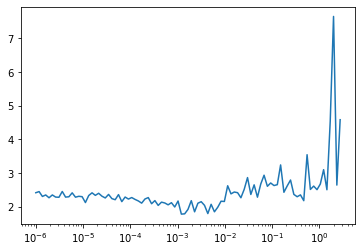

In [91]:
learn.recorder.plot(3)

In [94]:
#export
def create_phases(phases):
  phases = listify(phases)
  return phases + [1 - sum(phases)]

In [95]:
print(create_phases(0.3))
print(create_phase([0.3, 0.2]))

[0.3, 0.7]
[0.3, 0.2, 0.5]


In [100]:
#export
def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

In [102]:
lr = 1e-2
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr = combine_scheds(phases, cos_1cycle_anneal(lr/10,lr,lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95,0.85,0.95) )

In [103]:
cbsched = [
           ParamScheduler('lr', sched_lr),
           ParamScheduler('mom', sched_mom)]

In [104]:
learn = Learner(arch(), data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

In [105]:
learn.fit(5, cbs = cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.833004,0.425599,2.057150,0.394140,00:55
1,1.653729,0.518851,2.035579,0.392102,00:54
2,1.532608,0.573028,2.008011,0.445350,00:54
3,1.381965,0.639244,1.427076,0.633376,00:54
4,1.209191,0.715810,1.146603,0.753376,00:54


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**CNN_Learner**

In [107]:
def cnn_learner(arch, data, loss_func,opt_func, c_in=None, c_out=None,
                lr=1e-2, cuda=True, norm=None, progress=True, mixup=0,xtra_cb=None, **kwargs):
  cbfs = [partial(AvgStatsCallback,accuracy)] + listify(xtra_cb)
  if progress: cbfs.append(ProgressCallback)
  if cuda: cbfs.append(CudaCallback)
  if norm: cbfs.append(partial(BatchTransformXCallback, norm))
  if mixup: cbfs.append(partial(MixUp, mixup))
  arch_args = {}
  if not c_in: c_in = data.c_in
  if not c_out: c_out = data.c_out
  if c_in: arch_args['c_in'] = c_in
  if c_out: arch_args['c_out'] = c_out
  return Learner(arch(**arch_args), data, loss_func, opt_func=opt_func, lr=lr, cb_funcs=cbfs, **kwargs)

In [108]:
learn = cnn_learner(xresnet34, data, loss_func,opt_func, norm=norm_imagenette)

In [109]:
learn.fit(5, cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.817052,0.432464,2.763682,0.295796,00:55
1,1.659359,0.506284,1.709055,0.502420,00:54
2,1.548231,0.563312,1.522009,0.577070,00:54
3,1.366036,0.648432,1.303896,0.673885,00:54
4,1.197530,0.719823,1.152681,0.751592,00:54


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**IMAGENET**

In [110]:
!pip install fire

     |████████████████████████████████| 92kB 6.3MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115928 sha256=6869f2858350499a61fb67a95d412faec4c73108f433f3cb141f636ddddd0ff0
  Stored in directory: /root/.cache/pip/wheels/af/19/30/1ea0cad502dcb4e66ed5a690279628c827aea38bbbab75d5ed
Successfully built fire


In [111]:
!python notebook2script.py 11_train_imagennete.ipynb

Converted 11_train_imagennete.ipynb to exp/nb_11.py
